In [1]:
import pandas as pd
from database.market import Market
from database.strategy import Strategy
from database.sec import SEC
from modeler.modeler import Modeler as m
from datetime import datetime, timedelta, timezone
import numpy as np
import math
from tqdm import tqdm
import pickle
from sklearn.preprocessing import OneHotEncoder
from processor.processor import Processor as p
import statistics
import matplotlib.pyplot as plt

In [2]:
market = Market()

In [15]:
market.connect()
gfss = market.retrieve("general_financial_statement_sim")
sp5 = market.retrieve("sp500")
prices = market.retrieve("prices")
market.disconnect()

In [20]:
prices = p.column_date_processing(prices)
prices["year"] = [x.year -1  for x in prices["date"]]
prices["quarter"] = [x.quarter for x in prices["date"]]

In [17]:
gfss["year"] = gfss["year"] + 1

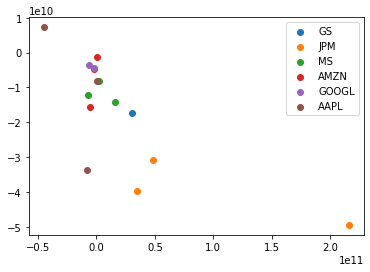

In [18]:
study = gfss[(gfss["ticker"].isin(["GS","JPM","MS","AMZN","GOOGL","AAPL"])) & (gfss["year"]==2021) & (gfss["quarter"]==2)]
for ticker in ["GS","JPM","MS","AMZN","GOOGL","AAPL"]:
    ticker_data = study[study["ticker"]==ticker]
    plt.scatter(ticker_data["netcashprovidedbyusedinfinancingactivities"],ticker_data["netcashprovidedbyusedininvestingactivities"])
plt.legend(["GS","JPM","MS","AMZN","GOOGL","AAPL"])
plt.show()

In [21]:
viz = gfss.merge(prices,on=["year","quarter","ticker"])

In [25]:
gfss

,year,quarter,ticker,assets,liabilitiesandstockholdersequity,netcashprovidedbyusedinfinancingactivities,netcashprovidedbyusedininvestingactivities,adjclose,y,skl_prediction,skl_score,xgb_prediction,xgb_score,cat_prediction,cat_score,prediction_gap,average_prediction,average_score
0,2010,2,ADBE,5.942672e+09,5.942672e+09,-3.647485e+08,-4.482250e+07,26.689683,33.062143,30.993344,0.941094,30.981798,0.937964,35.829450,0.926324,NaN,NaN,NaN
1,2010,2,ADSK,2.345100e+09,2.345100e+09,-1.029500e+08,-2.700000e+07,19.878571,30.111944,23.201849,0.941094,23.189579,0.937964,24.526366,0.926324,NaN,NaN,NaN
2,2010,2,CSX,2.642750e+10,2.642750e+10,4.335000e+08,-2.305000e+08,2.735117,4.795256,3.363103,0.941094,3.357717,0.937964,7.118194,0.926324,NaN,NaN,NaN
3,2010,2,CVX,1.602955e+11,1.602955e+11,-7.520000e+08,-4.203500e+09,40.827585,48.092344,46.385521,0.941094,46.432190,0.937964,44.932127,0.926324,NaN,NaN,NaN
4,2010,2,FCX,2.353050e+10,2.353050e+10,3.115000e+08,-5.015000e+08,18.611460,27.813766,21.643043,0.941094,21.638401,0.937964,23.060397,0.926324,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47943,2022,4,XLNX,5.104042e+09,5.104042e+09,-2.571150e+08,-2.346505e+08,80.889290,196.244093,129.204522,0.821959,129.187241,0.809265,128.889783,0.908857,3.0,97.570386,0.846694
47944,2022,4,XOM,3.516595e+11,3.516595e+11,-1.361900e+10,-1.002800e+10,64.965367,62.125348,99.435165,0.821959,99.624252,0.809265,78.912122,0.908857,3.0,70.242885,0.846694
47945,2022,4,XRAY,9.571850e+09,9.571850e+09,-1.699000e+08,-2.204000e+08,35.546055,54.993583,54.586964,0.821959,54.571480,0.809265,49.210912,0.908857,3.0,40.342339,0.846694
47946,2022,4,XYL,7.093000e+09,7.093000e+09,-5.200000e+07,-3.505000e+08,66.715024,124.175992,105.942615,0.821959,105.927055,0.809265,99.606546,0.908857,3.0,78.619054,0.846694


In [26]:
gfss[["assets","netcashprovidedbyusedinfinancingactivities","netcashprovidedbyusedininvestingactivities","adjclose"]].corr()

,assets,netcashprovidedbyusedinfinancingactivities,netcashprovidedbyusedininvestingactivities,adjclose
assets,1.000000,0.021835,-0.371612,-0.016168
netcashprovidedbyusedinfinancingactivities,0.021835,1.000000,-0.503445,-0.011268
netcashprovidedbyusedininvestingactivities,-0.371612,-0.503445,1.000000,-0.032883
adjclose,-0.016168,-0.011268,-0.032883,1.000000


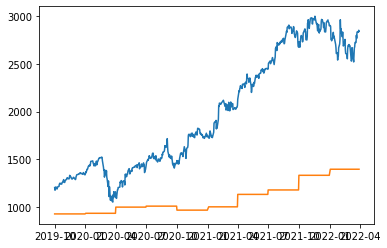

In [49]:
ticker = "GOOGL"
current = viz[viz["ticker"]==ticker].dropna().sort_values("date")
plt.plot(current["date"],current["adjclose_y"])
plt.plot(current["date"],current["average_prediction"])
plt.show()

In [67]:
recent_price = prices[prices["date"]==prices["date"].max()]
recent_predicts = gfss[(gfss["year"]==2022) & (gfss["quarter"]==2)].sort_values("ticker").dropna()
current_stats = recent_predicts.merge(recent_price,on="ticker").merge(sp5[["Symbol","GICS Sector"]].rename(columns={"Symbol":"ticker"}),on="ticker")


In [68]:
current_stats["delta"] = (current_stats["average_prediction"] - current_stats["adjclose_y"]) / current_stats["adjclose_y"]

In [74]:
current_stats[["GICS Sector","ticker","assets","adjclose_y","average_prediction","average_score","delta"]].sort_values("delta",ascending=False).head(50)

,GICS Sector,ticker,assets,adjclose_y,average_prediction,average_score,delta
72,Consumer Discretionary,CCL,4.148100e+10,19.60,70.471335,0.846694,2.595476
1,Industrials,AAL,5.303250e+10,18.05,50.086589,0.846694,1.774880
412,Consumer Discretionary,WYNN,1.244846e+10,81.17,209.800802,0.846694,1.584709
196,Information Technology,IPGP,2.432631e+09,113.34,279.682728,0.846694,1.467644
315,Consumer Discretionary,PVH,1.150420e+10,82.69,186.299918,0.846694,1.252992
166,Consumer Discretionary,GPS,7.661667e+09,14.65,31.468594,0.846694,1.148027
232,Consumer Discretionary,LVS,2.109550e+10,39.65,80.507280,0.846694,1.030448
47,Industrials,BA,1.129555e+11,194.91,392.463363,0.846694,1.013562
246,Consumer Discretionary,MHK,1.232761e+10,130.93,248.331534,0.846694,0.896674
380,Industrials,UAL,4.317925e+10,45.86,80.688988,0.846694,0.759463


In [72]:
current_stats.to_csv("q2_predictions")

In [75]:
current_stats[["GICS Sector","ticker","assets","adjclose_y","average_prediction","average_score","delta"]].groupby("GICS Sector").mean().reset_index().sort_values("delta",ascending=False)

,GICS Sector,assets,adjclose_y,average_prediction,average_score,delta
1,Consumer Discretionary,2.479333e+10,394.459455,267.310881,0.846694,-0.042350
3,Energy,7.059919e+10,83.159412,73.410225,0.846694,-0.065426
0,Communication Services,8.699179e+10,395.412632,239.399705,0.846694,-0.136322
6,Industrials,2.611095e+10,191.310317,133.696533,0.846694,-0.185457
2,Consumer Staples,3.713020e+10,123.521852,85.391770,0.846694,-0.224535
4,Financials,2.734858e+11,157.506909,107.220655,0.846694,-0.252487
9,Real Estate,1.647852e+10,161.236552,106.424722,0.846694,-0.273280
10,Utilities,2.823777e+10,81.671111,57.200623,0.846694,-0.277541
5,Health Care,3.366319e+10,275.138571,173.163387,0.846694,-0.299793
8,Materials,1.565591e+10,147.705238,102.607192,0.846694,-0.300239
